In [1]:
import datetime
import random
from dateutil import parser

import re
import ast
import itertools

import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

import src.ftx_wrapper as ftx_api
import src.analysis as analysis
import src.io as sio

In [2]:
!heroku logs --app funding-rate-bot -n 1500 > /Users/dineshpinto/PycharmProjects/trades-bot-analysis/logs/funding-rate-bot.log

In [3]:
df, orders, stop_losses, take_profits = sio.parse_logfile("logs/funding-rate-bot.log")

In [4]:
df = sio.add_into_dataframe(df, "data/funding_rate.csv")
orders = sio.add_into_pickle(orders, "data/orders.pkl")
stop_losses = sio.add_into_pickle(stop_losses, "data/stop_losses.pkl")
take_profits = sio.add_into_pickle(take_profits, "data/take_profits.pkl")

In [5]:
df_price = ftx_api.get_historical_data(start_time=df.index[0].timestamp(), end_time=df.index[-1].timestamp())

# Realtime

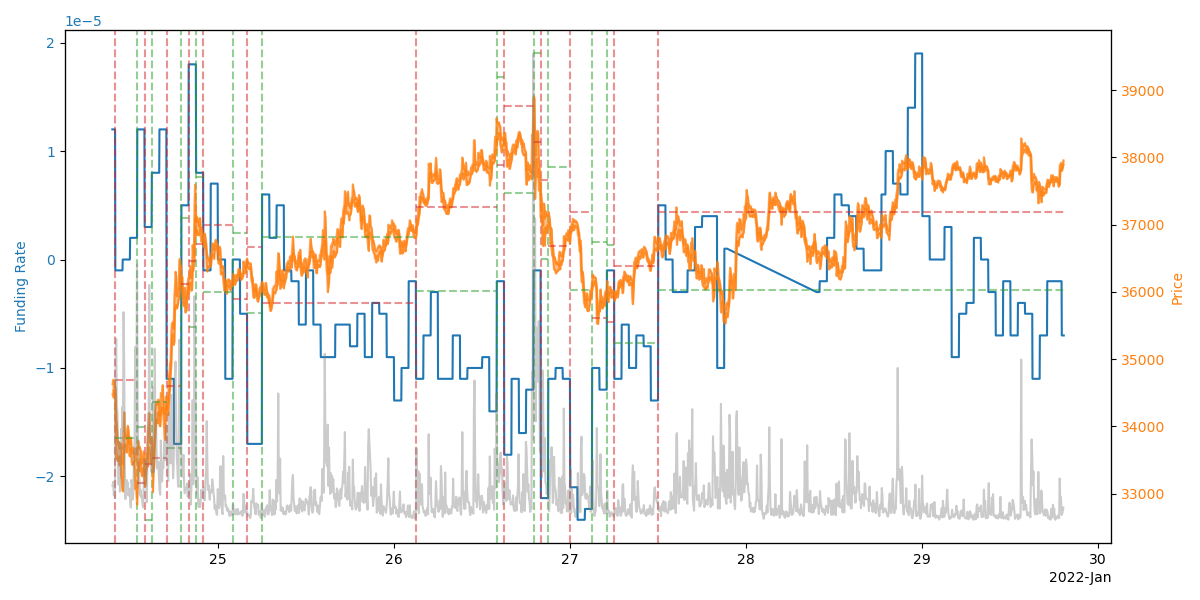

In [6]:
%matplotlib widget
fig, ax = plt.subplots(nrows=1, figsize=(12, 6))

ax.plot(df.index, df.funding_rate, "-")
ax.tick_params(axis='y', labelcolor="tab:blue")
ax.set_ylabel("Funding Rate", color="tab:blue")

ax2 = ax.twinx()
#ax2.plot(df.index, df.price, color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange")
ax2.set_ylabel("Price", color="tab:orange")

ax2.plot(df_price.index, df_price.low, color="tab:orange", alpha=0.7)
ax2.plot(df_price.index, df_price.high, color="tab:orange", alpha=0.7)
ax2.fill_between(df_price.index, df_price.low, df_price.high, color="tab:orange", alpha=0.5)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

success = []

for idx, (order, stop_loss, take_profit) in enumerate(zip(orders, stop_losses, take_profits)):     
    if order["side"] == "buy":
        ax.axvline(parser.parse(order["createdAt"]), linestyle="--", color="tab:green", alpha=0.5)
    elif order["side"] == "sell":
        ax.axvline(parser.parse(order["createdAt"]), linestyle="--", color="tab:red", alpha=0.5)

    try:
        ax2.plot((parser.parse(stop_loss["createdAt"]), parser.parse(stop_losses[idx+1]["createdAt"])), 
                 (stop_loss["triggerPrice"], stop_loss["triggerPrice"]), 
                 linestyle="--", color='tab:red', alpha=0.5)
        ax2.plot((parser.parse(take_profit["createdAt"]), parser.parse(take_profits[idx+1]["createdAt"])), 
                 (take_profit["triggerPrice"], take_profit["triggerPrice"]), 
                 linestyle="--", color='tab:green', alpha=0.5)
    except Exception as exc:
        ax2.plot((parser.parse(stop_loss["createdAt"]), df.index[-1]), (stop_loss["triggerPrice"], stop_loss["triggerPrice"]),
                 linestyle="--", color='tab:red', alpha=0.5)
        ax2.plot((parser.parse(take_profit["createdAt"]), df.index[-1]), (take_profit["triggerPrice"], take_profit["triggerPrice"]), 
                 linestyle="--", color='tab:green', alpha=0.5)

ax3 = ax.twinx()
ax3.plot(df_price.index, df_price.volume, color="tab:grey", alpha=0.4)
ax3.set_ylabel("Volume")
ax3.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax3.xaxis.get_major_locator()))
ax3.set_yticks([])
ax3.set_ylabel("")

fig.tight_layout()

# Simulator

╒══════════╤═══════════╕
│ Profit   │   Percent │
╞══════════╪═══════════╡
│ Net      │      11.6 │
├──────────┼───────────┤
│ Median   │       3.4 │
├──────────┼───────────┤
│ Mean     │       1.9 │
├──────────┼───────────┤
│ Min      │      -3.3 │
├──────────┼───────────┤
│ Max      │       4.3 │
╘══════════╧═══════════╛


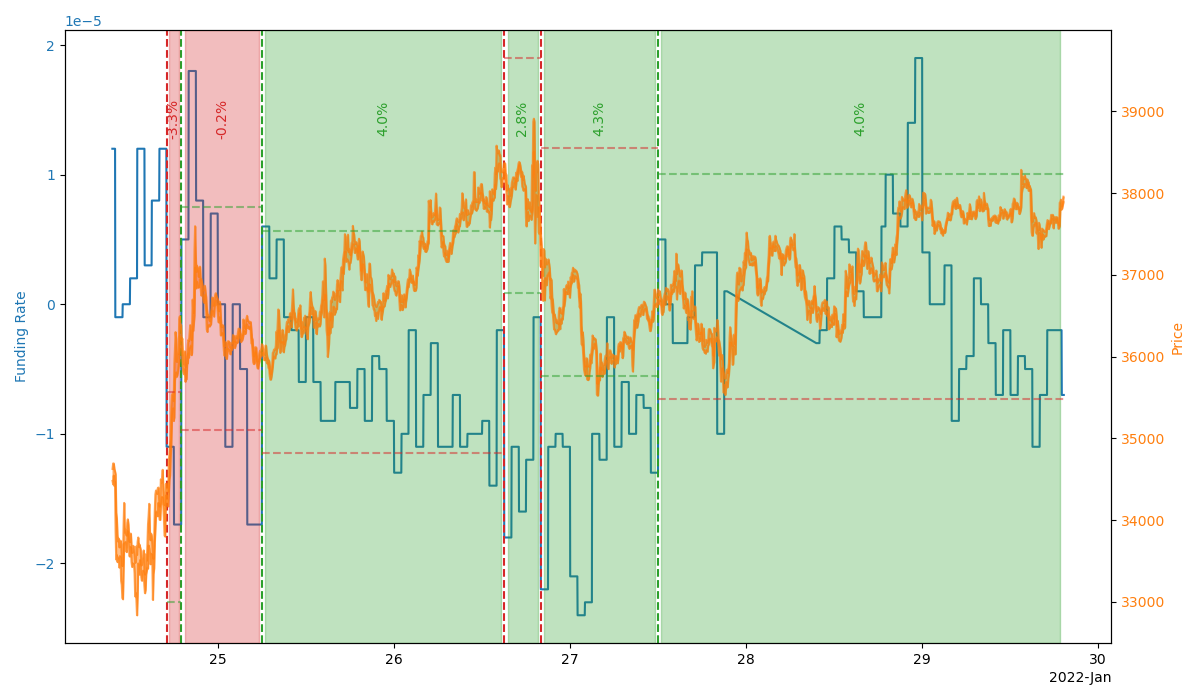

In [33]:
%matplotlib widget
fig, ax = plt.subplots(nrows=1, figsize=(12, 7))

ax.plot(df.index, df.funding_rate, "-")
ax.tick_params(axis='y', labelcolor="tab:blue")
ax.set_ylabel("Funding Rate", color="tab:blue")

ax2 = ax.twinx()
#ax2.plot(df.index, df.price, color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange")
ax2.set_ylabel("Price", color="tab:orange")

ax2.plot(df_price.index, df_price.low, color="tab:orange", alpha=0.7)
ax2.plot(df_price.index, df_price.high, color="tab:orange", alpha=0.7)
ax2.fill_between(df_price.index, df_price.low, df_price.high, color="tab:orange", alpha=0.5)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

target_funding_rate_change = 1.5e-3
tp_percent, sl_percent = 4, 3.5

order_indexes, positions, take_profits, stop_losses, profitability = analysis.test_trade_setup(target_funding_rate_change, tp_percent, sl_percent, 
                                                                                               df, df_price, ax1=ax, ax2=ax2, plot=True)

table = [
    ["Profit", "Percent"],
    ["Net", f"{np.sum(profitability):.1f}"],
    ["Median", f"{np.median(profitability):.1f}"],
    ["Mean", f"{np.mean(profitability):.1f}"],
    ["Min", f"{np.min(profitability):.1f}"],
    ["Max", f"{np.max(profitability):.1f}"]
]
print(tabulate(table, tablefmt="fancy_grid", headers="firstrow"))
fig.tight_layout()

# Optimizer

In [150]:
target_funding_rate_changes = np.linspace(5e-4, 1.5e-3, 15)
tp_percents = np.linspace(1, 8, 15)
sl_percents = np.linspace(1, 8, 15)

total_size = len(target_funding_rate_changes) * len(tp_percents) * len(sl_percents)

net_profits = np.zeros(total_size)
median_profits = np.zeros(total_size)
mean_profits = np.zeros(total_size)

pbar = tqdm.tqdm(itertools.product(tp_percents, sl_percents, target_funding_rate_changes))

for idx, (tp_percent, sl_percent, target_funding_rate_change) in enumerate(pbar):
    order_indexes, positions, take_profits, stop_losses, profitability = analysis.test_trade_setup(target_funding_rate_change, tp_percent, sl_percent, 
                                                                                                   df, df_price, ax1=ax, ax2=ax2, plot=False)
    pbar.set_description(f"Total = {total_size}")
    net_profits[idx] = np.sum(profitability)
    median_profits[idx] = np.median(profitability)
    mean_profits[idx] = np.mean(profitability)

Total = 2250: : 3375it [02:18, 24.39it/s]


In [154]:
X1 = np.zeros(total_size)
Y1 = np.zeros(total_size)
Z1 = np.zeros(total_size)

for idx, (tp_percent, sl_percent, target_funding_rate_change) in enumerate(itertools.product(tp_percents, sl_percents, target_funding_rate_changes)):
    X1[idx] = tp_percent
    Y1[idx] = sl_percent
    Z1[idx] = target_funding_rate_change

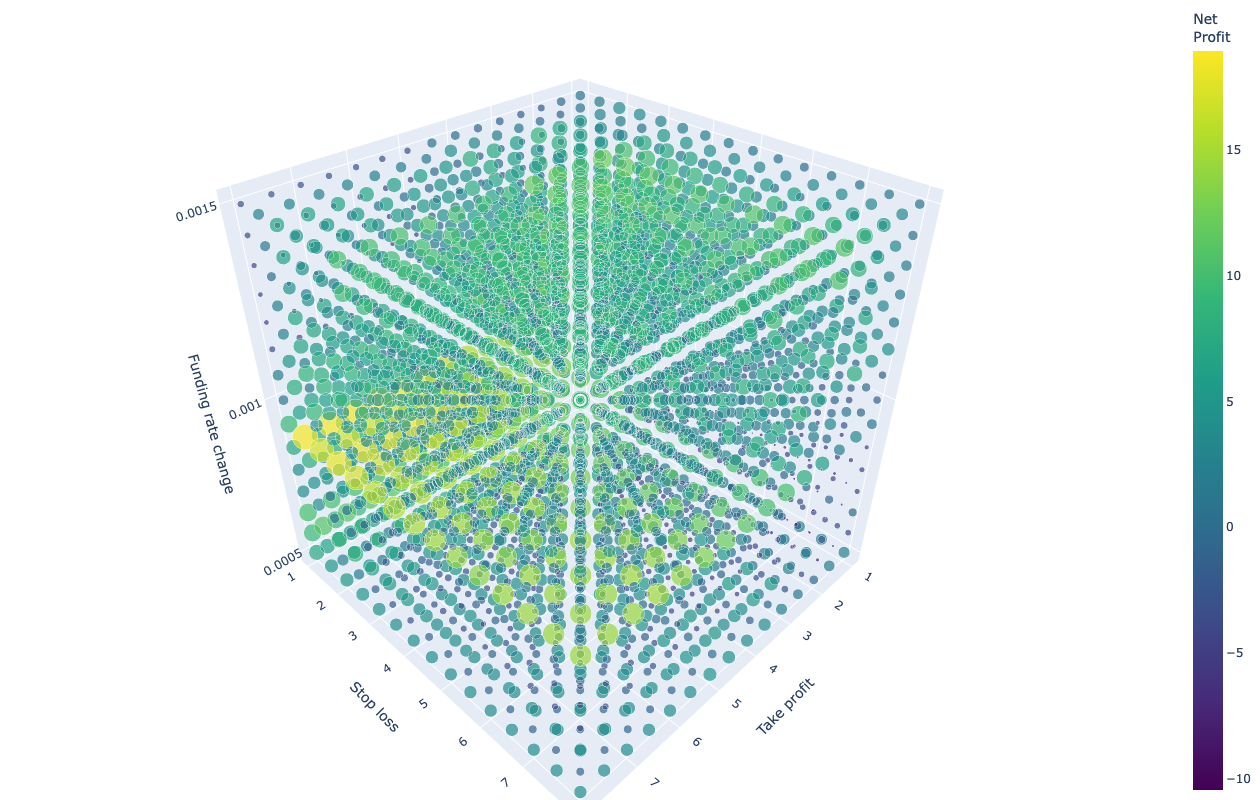

In [161]:
fig = go.Figure(data=go.Scatter3d(
    x=X1,
    y=Y1,
    z=Z1,
    mode='markers+text',
    marker=dict(
        sizemode='diameter',
        size=net_profits + abs(min(net_profits)),
        color=net_profits,
        colorscale = 'Viridis',
        colorbar_title = 'Net<br>Profit',
    ),
))

fig.update_layout(
    scene=dict(
        xaxis_title='Take profit',
        yaxis_title='Stop loss',
        zaxis_title='Funding rate change'
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    width=1200,
    height=800,
)
fig.show()

In [ ]:
for idx, (tp_percent, sl_percent, target_funding_rate_change) in enumerate(itertools.product(tp_percents, sl_percents, target_funding_rate_changes)):
    if idx == np.argmax(C):
        table = [
            ["Parameter", "Value"],
            ["Take profit", f"{tp_percent:.2f}%"],
            ["Stop loss", f"{sl_percent:.2f}%"],
            ["Funding rate change", f"{target_funding_rate_change:.2e}"],
        ]
        print(tabulate(table, tablefmt="fancy_grid", headers="firstrow"))
        break